# Benchmark deconvolution performance on synthetic ST data (Fig 2)

In [1]:
import itertools
import warnings
import torch
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib
import matplotlib.pyplot as plt

from plotnine import *
from plotnine_prism import *

In [2]:
pal = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F', '#8491B4', '#91D1C2', '#DC0000', '#7E6148', '#B09C85']
from plotnine.scales.scale import scale_discrete
class scale_fill_npg(scale_discrete):
    """GGSCI-NPG fill scale
    Args:
        palette: The fill palette name
    """

    _aesthetics = ["fill"]
    na_value = "#7F7F7F"

    def __init__(self, palette="colors", **kwargs):
        """Construct"""
        self.palette = lambda n: pal[:n]
        scale_discrete.__init__(self, **kwargs)

## Synthetic donut data

### Load donut deconvolution results

In [3]:
def load_deconv_results(data_dir, res_dir, num_exp = 10):
    # load true cell type abundances
    ab_true = pd.read_csv(data_dir + f"/celltype_abundances.csv", header = 0, index_col = 0)
    celltypes = ab_true.columns

    # calculate proportion
    p_true = pd.DataFrame(
        ab_true.to_numpy() / (ab_true.to_numpy().sum(axis=1, keepdims=True) + 1e-10),
        index = ab_true.index, columns = ab_true.columns
    )
    
    # [n_spots x n_celltypes, ...]
    p_true_exp_list = [p_true.iloc[(2500*exp):(2500 + 2500*exp),:].to_numpy()
                       for exp in range(num_exp)]

    # load spatial pattern annotation
    design = pd.read_csv(data_dir + f"/celltype_zone_assignment.csv", header = 0, index_col = 0)
    design = design.loc[celltypes,:]
    
    # load deconvolution results
    file_names = ['torch/' + n for n in ['nnls', 'nnls_sp', 'svr', 'svr_sp',
                                         'dwls', 'dwls_sp', 'lnr', 'lnr_sp']]
    file_names += ['card/' + n for n in ['card', 'card_sp']]

    # [n_methods x n_spots x n_celltypes, ...]
    p_inf_exp_list = [
        np.stack([np.loadtxt(f"{res_dir}/{name}_e{exp}.txt") for name in file_names])
        for exp in range(num_exp)]
    
    return p_true_exp_list, p_inf_exp_list, design


def _array2df(array, value_name, method_names, design):
    # array: n_celltypes x n_methods
    df = pd.DataFrame(array, columns = method_names)
    df['cell_type'] = design.index
    df['is_high_density'] = design['is_high_density'][df['cell_type']].values
    df = pd.melt(
        df, id_vars=['cell_type', 'is_high_density'],
        var_name='model', value_name=value_name
    )
    df['spatial_loss'] = df['model'].str.contains('spatial')
    df['spatial_loss_cat'] = pd.Categorical(df.spatial_loss, [True, False])
    df['deconv_model'] = df['model'].str.split('+').str[0].str.strip()
    df['cell_type_class'] = np.where(df.is_high_density, 'High', 'Low')
    
    return df

def calc_deconv_stats(p_true_exp_list, p_inf_exp_list, design, method_names, 
                      corr_metric = 'pearson', accu_metric = 'pr'):
    err_exp_df = [] # absolute deconv error
    corr_exp_df = [] # deconv correlation
    accu_exp_df = [] # binary accuracy metric

    # check correlation metric
    assert corr_metric in ['pearson', 'spearman']
    if corr_metric == 'pearson':
        corr_func = lambda p_true, p_inf: np.corrcoef(p_true, p_inf)[0,1]
    else:
        corr_func = lambda p_true, p_inf: sp.stats.spearmanr(p_true, p_inf).correlation
    
    # check binary accuracy metric
    assert accu_metric in ['roc', 'pr']
    if accu_metric == 'roc':
        _accu_func = roc_auc_score
    else:
        _accu_func = average_precision_score
        
    def accu_func(y_true, y_inf, **kwargs):
        try:
            return _accu_func(y_true, y_inf, average='micro', **kwargs)
        except ValueError as verr:
            #print(f"Return NaN accuracy because of the following error: {verr}")
            return np.nan
    
    # iterate over experiments        
    for exp, (p_true_exp, p_inf_exp) in enumerate(zip(p_true_exp_list, p_inf_exp_list)):
        # calculate mean square error of cell type proportions
        err_df = np.stack([((p_true_exp - p_inf_exp[model,:,:]) ** 2).mean(axis=0) 
                           for model in range(p_inf_exp.shape[0])], axis=1)
        err_df = _array2df(err_df, 'mse', method_names, design)
        err_df['exp'] = exp
        err_exp_df.append(err_df)

        # calculate pearson correlation between true and predicted
        corr_df = np.stack(
            [np.array([corr_func(p_true_exp[:,i].flatten(), p_inf_m[:, i].flatten())
                       for i in range(p_true_exp.shape[1])])
             for p_inf_m in p_inf_exp], axis = 1)
        corr_df = _array2df(corr_df, 'corr', method_names, design)
        corr_df['exp'] = exp
        corr_exp_df.append(corr_df)

        # calculate binary prediction accuracy
        is_ct_present = p_true_exp >= 0.05
        accu_df = np.stack(
            [np.array([accu_func(is_ct_present[:,i].flatten(), p_inf_m[:, i].flatten())
                       for i in range(p_true_exp.shape[1])])
             for p_inf_m in p_inf_exp], axis = 1)
        accu_df = _array2df(accu_df, 'accu', method_names, design)
        accu_df['exp'] = exp
        accu_exp_df.append(accu_df)
        
    err_exp_df = pd.concat(err_exp_df)
    corr_exp_df = pd.concat(corr_exp_df)
    accu_exp_df = pd.concat(accu_exp_df)
    
    return err_exp_df, corr_exp_df, accu_exp_df


In [4]:
data_dir = "/Users/jysumac/Projects/Smoother_paper/data/synthetic_deconv/donut/ne10_rz15_nm50_sm0.1/"
res_dir = "/Users/jysumac/Projects/Smoother_paper/results/synthetic_deconv/donut/ne10_rz15_nm50_sm0.1/"
method_names = ['NNLS', 'NNLS + spatial', 
                'SVR', 'SVR + spatial', 
                'DWLS', 'DWLS + spatial',
                'LNR', 'LNR + spatial']
method_names += ['CARD', 'CARD + spatial']

corr_metric='pearson'
accu_metric='pr'

p_true_exp_list, p_inf_exp_list, design = load_deconv_results(data_dir, res_dir)

# calculate performance stats
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    err_exp_df, corr_exp_df, accu_exp_df  = calc_deconv_stats(
        p_true_exp_list, p_inf_exp_list, design, method_names, corr_metric, accu_metric)

def _cat_df(df):
    df['deconv_model'] = pd.Categorical(df.deconv_model,
                                       ['NNLS', 'DWLS', 'SVR', 'LNR', 'CARD'])
    return df

err_all_df = _cat_df(err_exp_df)
corr_all_df = _cat_df(corr_exp_df)
accu_all_df = _cat_df(accu_exp_df)

### Visualization (Fig 2a-d)

#### NNLS results on selected slides (Fig 2a and c)

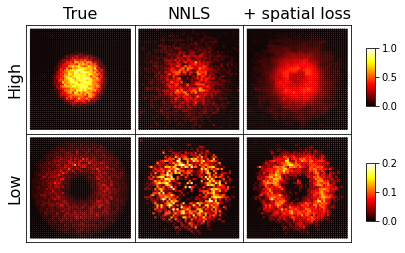

In [5]:
ct_to_plot = ['Oligo_2', 'Inh_6']
ct_to_plot = ['Inh_1', 'Inh_6']

ct_idx = [np.nonzero(design.index == ct)[0].item() for ct in ct_to_plot]
EXP_ID = 0

coords = pd.read_csv(data_dir + f"/deconv_inputs/coords_exp{EXP_ID}.csv", header = 0, index_col = 0)


# visualization
# colored by coefficients layer-by-layer
fig, axes = plt.subplots(
    len(ct_idx), 3, 
    figsize=(6.5, 4)
)


fontsize = 16
vmin_hi, vmax_hi = 0, 1
vmin_low, vmax_low = 0, 0.2
cmap = 'hot'

# high-density cell type
axes[0][0].scatter(coords['x'], coords['y'],
                   s = 2.5, cmap = cmap,
                   c = p_true_exp_list[EXP_ID][:,ct_idx[0]],
                   vmin=vmin_hi, vmax=vmax_hi)

# low-density cell type
axes[1][0].scatter(coords['x'], coords['y'],
                   s = 2.5, cmap = cmap,
                   c = p_true_exp_list[EXP_ID][:,ct_idx[1]],
                   vmin=vmin_low, vmax=vmax_low)

for m, name in enumerate(['NNLS', '+ spatial loss']):
    axes[0][1 + m].set_title(name, fontsize=fontsize)
    a = axes[0][1 + m].scatter(coords['x'], coords['y'], 
                               s = 2.5, cmap = cmap,
                               c = p_inf_exp_list[EXP_ID][m + 2][:, ct_idx[0]],
                               vmin=vmin_hi, vmax=vmax_hi)
    b = axes[1][1 + m].scatter(coords['x'], coords['y'],
                               s = 2.5, cmap = cmap,
                               c = p_inf_exp_list[EXP_ID][m + 2][:, ct_idx[1]],
                               vmin=vmin_low, vmax=vmax_low)


for i, idx in enumerate(ct_idx):
    if len(ct_idx) == 1:
        ax = axes
    else:
        ax = axes[i]

fig.subplots_adjust(right=0.82)
cbar_ax1 = fig.add_axes([0.85, 0.6, 0.02, 0.2])
cbar_ax2 = fig.add_axes([0.85, 0.2, 0.02, 0.2])
fig.colorbar(a, cax=cbar_ax1)
fig.colorbar(b, cax=cbar_ax2)

if len(ct_idx) == 1:
    ax = axes
else:
    ax = axes[0]
ax[0].set_title("True", fontsize=fontsize)
axes[0][0].set_ylabel('High', fontsize=fontsize)
axes[1][0].set_ylabel('Low', fontsize=fontsize)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()

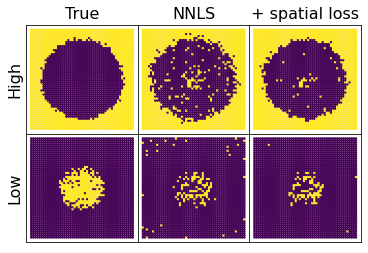

In [6]:
ct_to_plot = ['Inh_Meis2_3', 'Astro_CTX']
ct_idx = [np.nonzero(design.index == ct)[0].item() for ct in ct_to_plot]

ab_thred = 0.05

# visualization
# colored by coefficients layer-by-layer
fig, axes = plt.subplots(
    len(ct_idx), 3, 
    figsize=(6, 4)
)
for i, idx in enumerate(ct_idx):
    if len(ct_idx) == 1:
        ax = axes
    else:
        ax = axes[i]
    ax[0].scatter(coords['x'], coords['y'], c = p_true_exp_list[EXP_ID][:,idx] >= ab_thred, s = 2.5)
    
    for m, name in enumerate(['NNLS', '+ spatial loss']):
        ax[1 + m].scatter(coords['x'], coords['y'], c = p_inf_exp_list[EXP_ID][m][:, idx] >= ab_thred, s = 2.5)
        if i == 0:
            ax[1 + m].set_title(name, fontsize=fontsize)

if len(ct_idx) == 1:
    ax = axes
else:
    ax = axes[0]
ax[0].set_title("True", fontsize=fontsize)
axes[0][0].set_ylabel('High', fontsize=fontsize)
axes[1][0].set_ylabel('Low', fontsize=fontsize)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()

#### Deconvolute accuracy (Fig 2b)

/Users/jysumac/miniforge3/envs/sp_dev/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/jysumac/miniforge3/envs/sp_dev/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


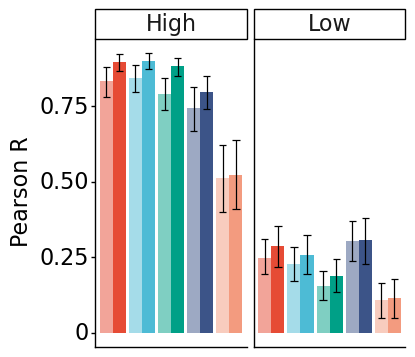

<ggplot: (368611277)>

In [7]:
p1 = (
    ggplot(corr_all_df, 
          aes(x='deconv_model', y = 'corr', group = 'model')) +
    facet_wrap('~ cell_type_class', scales = 'fixed') +
    geom_bar(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge", stat = "summary",
                fun_y = np.mean) +
    scale_fill_npg() + 
    scale_alpha_manual([0.5,1]) +
    geom_errorbar(stat = "summary", position = position_dodge(width=0.9)) +
    labs(x = '', y = 'Pearson R',
            fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (4, 4), 
          strip_text_x = element_text(size = fontsize),
          axis_title_y = element_text(size = fontsize),
          axis_text_y = element_text(size = fontsize, color = 'black'),
          axis_text_x=element_blank(),
          axis_ticks_major_x=element_blank(),
          legend_position='none')
)

p1

#### Binary prediction performance (Fig 2d)

/Users/jysumac/miniforge3/envs/sp_dev/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/jysumac/miniforge3/envs/sp_dev/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/jysumac/miniforge3/envs/sp_dev/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_summary : Removed 100 rows containing non-finite values.
/Users/jysumac/miniforge3/envs/sp_dev/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_summary : Removed 100 rows containing non-finite values.


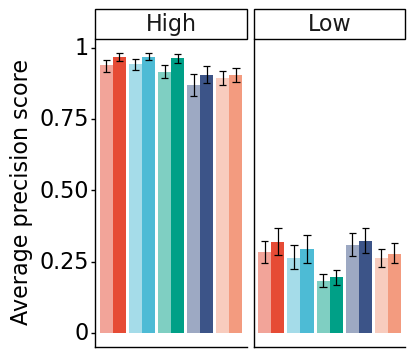

<ggplot: (368850396)>

In [8]:
p2 = (
    ggplot(accu_all_df, 
          aes(x='deconv_model', y = 'accu', group = 'model')) +
    facet_wrap('~ cell_type_class', scales = 'fixed') +
    geom_bar(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge", stat = "summary",
                fun_y = np.mean) +
    scale_fill_npg() + 
    scale_alpha_manual([0.5,1]) +
    geom_errorbar(stat = "summary", position = position_dodge(width=0.9)) +
    labs(x = '', y = 'Average precision score',
            fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (4, 4), 
          strip_text_x = element_text(size = fontsize),
          axis_title_y = element_text(size = fontsize),
          axis_text_y = element_text(size = fontsize, color = 'black'),
          axis_text_x=element_blank(),
          axis_ticks_major_x=element_blank(),
          legend_position='none')
)

p2

## Sci-Space synthetic data

### Load sci_space deconvolution results

In [9]:
def load_deconv_results(data_dir, res_dir, num_slides = 14):
    # load reference expression profiles
    df_x = pd.read_csv(data_dir + "ref_avg_norm_count_markers.csv", header = 0, index_col = 0)
    celltypes = df_x.columns
    
    coords = []
    p_true_s_list = []
    
    for s in range(num_slides):
        # spatial coordinates, num_spot x 2
        meta = pd.read_csv(data_dir + f"/slide_{s+1}/meta_grids.csv", sep = ",", header=0, index_col=0)
        coords.append(meta.loc[:, ['Row', 'Col']])

        p_true_s = meta.loc[:, celltypes].to_numpy() / (meta['total'].to_numpy()[:, None] + 1e-10)
        p_true_s_list.append(p_true_s)

    # load deconvolution results
    file_names = ['torch/' + n for n in ['nnls', 'nnls_sp', 'svr', 'svr_sp',
                                         'dwls', 'dwls_sp', 'lnr', 'lnr_sp']]
    file_names += ['card/' + n for n in ['card', 'card_sp']]

    # [n_methods x n_spots x n_celltypes, ...]
    p_inf_s_list = [
        np.stack([np.loadtxt(f"{res_dir}/{name}_s{s + 1}.txt") for name in file_names])
        for s in range(num_slides)]
    
    return p_true_s_list, p_inf_s_list, celltypes, coords


def _array2df(array, value_name, method_names, celltypes):
    # array: n_celltypes x n_methods
    df = pd.DataFrame(array, columns = method_names)
    df['cell_type'] = celltypes
    df = pd.melt(
        df, id_vars=['cell_type'],
        var_name='model', value_name=value_name
    )
    df['spatial_loss'] = df['model'].str.contains('spatial')
    df['spatial_loss_cat'] = pd.Categorical(df.spatial_loss, [True, False])
    df['deconv_model'] = df['model'].str.split('+').str[0].str.strip()
    
    return df

def calc_deconv_stats(p_true_s_list, p_inf_s_list, celltypes, method_names, 
                      corr_metric = 'pearson', accu_metric = 'pr'):
    err_s_df = [] # absolute deconv error
    corr_s_df = [] # deconv correlation
    accu_s_df = [] # binary accuracy metric

    # check correlation metric
    assert corr_metric in ['pearson', 'spearman']
    if corr_metric == 'pearson':
        corr_func = lambda p_true, p_inf: np.corrcoef(p_true, p_inf)[0,1]
    else:
        corr_func = lambda p_true, p_inf: sp.stats.spearmanr(p_true, p_inf).correlation
    
    # check binary accuracy metric
    assert accu_metric in ['roc', 'pr']
    if accu_metric == 'roc':
        _accu_func = roc_auc_score
    else:
        _accu_func = average_precision_score
        
    def accu_func(y_true, y_inf, **kwargs):
        try:
            return _accu_func(y_true, y_inf, average='micro', **kwargs)
        except ValueError as verr:
            #print(f"Return NaN accuracy because of the following error: {verr}")
            return np.nan
    
    # iterate over experiments        
    for s, (p_true_s, p_inf_s) in enumerate(zip(p_true_s_list, p_inf_s_list)):
        # calculate mean square error of cell type proportions
        err_df = np.stack([((p_true_s - p_inf_s[model,:,:]) ** 2).mean(axis=0) 
                           for model in range(p_inf_s.shape[0])], axis=1)
        err_df = _array2df(err_df, 'mse', method_names, celltypes)
        err_df['slide'] = s
        err_s_df.append(err_df)

        # calculate pearson correlation between true and predicted
        corr_df = np.stack(
            [np.array([corr_func(p_true_s[:,i].flatten(), p_inf_m[:, i].flatten())
                       for i in range(p_true_s.shape[1])])
             for p_inf_m in p_inf_s], axis = 1)
        corr_df = _array2df(corr_df, 'corr', method_names, celltypes)
        corr_df['slide'] = s
        corr_s_df.append(corr_df)

        # calculate binary prediction accuracy
        is_ct_present = p_true_s >= 0.05
        accu_df = np.stack(
            [np.array([accu_func(is_ct_present[:,i].flatten(), p_inf_m[:, i].flatten())
                       for i in range(p_true_s.shape[1])])
             for p_inf_m in p_inf_s], axis = 1)
        accu_df = _array2df(accu_df, 'accu', method_names, celltypes)
        accu_df['slide'] = s
        accu_s_df.append(accu_df)
        
    err_s_df = pd.concat(err_s_df)
    corr_s_df = pd.concat(corr_s_df)
    accu_s_df = pd.concat(accu_s_df)
    
    return err_s_df, corr_s_df, accu_s_df

In [10]:
method_names = ['NNLS', 'NNLS + spatial', 
                'SVR', 'SVR + spatial', 
                'DWLS', 'DWLS + spatial',
                'LNR', 'LNR + spatial']
method_names += ['CARD', 'CARD + spatial']

corr_metric='pearson'
accu_metric='pr'


data_dir = f"/Users/jysumac/Projects/Smoother_paper/data/synthetic_deconv/sci_space/deconv_inputs/"
res_dir = f"/Users/jysumac/Projects/Smoother_paper/results/synthetic_deconv/sci_space/"

# load deconv results
p_true_s_list, p_inf_s_list, celltypes, coords_l = load_deconv_results(data_dir, res_dir)

# calculate performance stats
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    err_s_df, corr_s_df, accu_s_df  = calc_deconv_stats(
        p_true_s_list, p_inf_s_list, celltypes, method_names, corr_metric, accu_metric)

def _cat_df(df):
    df['deconv_model'] = pd.Categorical(df.deconv_model,
                                       ['NNLS', 'DWLS', 'SVR', 'LNR', 'CARD'])
    return df

err_all_df = _cat_df(err_s_df)
corr_all_df = _cat_df(corr_s_df)
accu_all_df = _cat_df(accu_s_df)

### Visualization (Fig 2e-h)

#### NNLS results on selected cell types (Fig 2e and f)

In [11]:
celltypes

Index(['Chondrocytes', 'ConnectiveTissueProgenitors', 'EndothelialCells',
       'EpithelialCells', 'ErythroidLineage', 'LateralPlateMesoderm',
       'Myocytes', 'Neuron'],
      dtype='object')

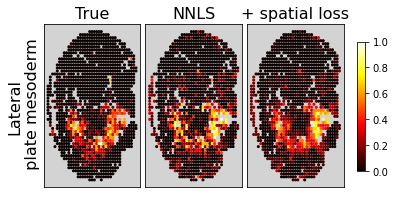

In [12]:
ct_to_plot = ['LateralPlateMesoderm']
ct_idx = [np.nonzero(celltypes == ct)[0].item() for ct in ct_to_plot]
S_ID = 13

coords = coords_l[S_ID]

# visualization
# colored by coefficients layer-by-layer
fig, axes = plt.subplots(
    len(ct_idx), 3, 
    figsize=(6, 3)
)

fontsize = 16
vmin, vmax = 0, 1
cmap = 'hot'

for i, idx in enumerate(ct_idx):
    if len(ct_idx) == 1:
        ax = axes
    else:
        ax = axes[i]
    ax[0].scatter(coords['Row'], coords['Col'], 
                  c = p_true_s_list[S_ID][:,idx], 
                  s = 4, cmap = cmap,
                  vmin=vmin, vmax=vmax)
    
    for m, name in enumerate(['NNLS', '+ spatial loss']):
        a = ax[1 + m].scatter(coords['Row'], coords['Col'],
                          c = p_inf_s_list[S_ID][m][:, idx],
                          s = 4, cmap = cmap,
                          vmin=vmin, vmax=vmax)
        if i == 0:
            ax[1 + m].set_title(name, fontsize = fontsize)

if len(ct_idx) == 1:
    ax = axes
else:
    ax = axes[0]
ax[0].set_title("True", fontsize = fontsize)
#ax[0].set_ylabel(ct_to_plot[0], fontsize = fontsize)
ax[0].set_ylabel('Lateral\n plate mesoderm', fontsize = fontsize)

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(a, cax=cbar_ax)

for ax in axes.flatten():
    ax.set_facecolor('lightgray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.05, hspace=0.0)
plt.show()

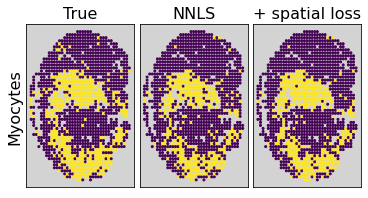

In [13]:
ct_to_plot = ['Myocytes']
ct_idx = [np.nonzero(celltypes == ct)[0].item() for ct in ct_to_plot]

# visualization
# colored by coefficients layer-by-layer
fig, axes = plt.subplots(
    len(ct_idx), 3, 
    figsize=(6, 3)
)
for i, idx in enumerate(ct_idx):
    if len(ct_idx) == 1:
        ax = axes
    else:
        ax = axes[i]
    ax[0].scatter(coords['Row'], coords['Col'], c = p_true_s_list[S_ID][:,idx] >= 0.05, s = 4)
    
    for m, name in enumerate(['NNLS', '+ spatial loss']):
        ax[1 + m].scatter(coords['Row'], coords['Col'], c = p_inf_s_list[S_ID][m][:, idx] >= 0.05, s = 4)
        if i == 0:
            ax[1 + m].set_title(name, fontsize = fontsize)

if len(ct_idx) == 1:
    ax = axes
else:
    ax = axes[0]
ax[0].set_title("True", fontsize = fontsize)

ax[0].set_ylabel(ct_to_plot[0], fontsize = fontsize)

for ax in axes.flatten():
    ax.set_facecolor('lightgray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.05, hspace=0.0)
plt.show()

#### Deconvolute accuracy (Fig 2f)

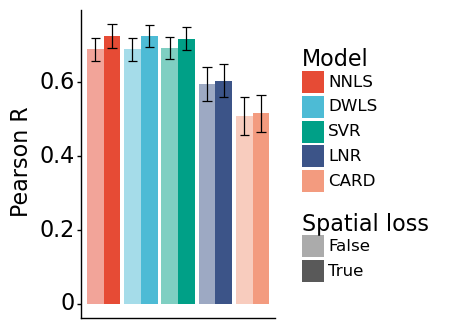

<ggplot: (382213051)>

In [14]:
p3 = (
    ggplot(corr_all_df, 
          aes(x='deconv_model', y = 'corr', group = 'model')) +
    geom_bar(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge", stat = "summary",
                fun_y = np.mean) +
    scale_fill_npg() +
    scale_alpha_manual([0.5,1]) +
    geom_errorbar(stat = "summary", position = position_dodge(width=0.9)) +
    labs(x = '', y = 'Pearson R',
            fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (2.5, 4), 
          strip_text_x = element_text(size = fontsize),
          axis_title_y = element_text(size = fontsize),
          axis_text_y = element_text(size = fontsize, color = 'black'),
          axis_text_x=element_blank(),
          axis_ticks_major_x=element_blank(),
          legend_text = element_text(size = fontsize - 4),
          legend_title = element_text(size = fontsize),
          legend_position='right')
)

p3

#### Binary prediction performance (Fig 2h)

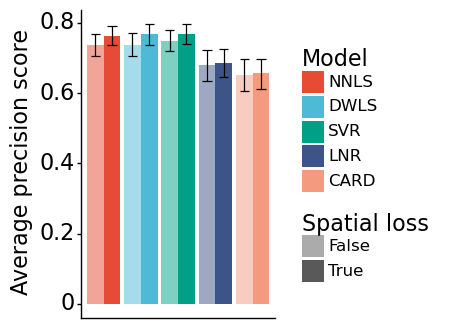

<ggplot: (368842728)>

In [15]:
p4 = (
    ggplot(accu_all_df, 
          aes(x='deconv_model', y = 'accu', group = 'model')) +
    geom_bar(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge", stat = "summary",
                fun_y = np.mean) +
    scale_fill_npg() + 
    scale_alpha_manual([0.5,1]) +
    geom_errorbar(stat = "summary", position = position_dodge(width=0.9)) +
    labs(x = '', y = 'Average precision score',
            fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (2.5, 4), 
          strip_text_x = element_text(size = fontsize),
          axis_title_y = element_text(size = fontsize),
          axis_text_y = element_text(size = fontsize, color = 'black'),
          axis_text_x=element_blank(),
          axis_ticks_major_x=element_blank(),
          legend_text = element_text(size = fontsize - 4),
          legend_title = element_text(size = fontsize),
          legend_position='right')
)

p4